# Camera Calibration

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mping
import glob

# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

Text(0.5,1,'Undistorted Image')

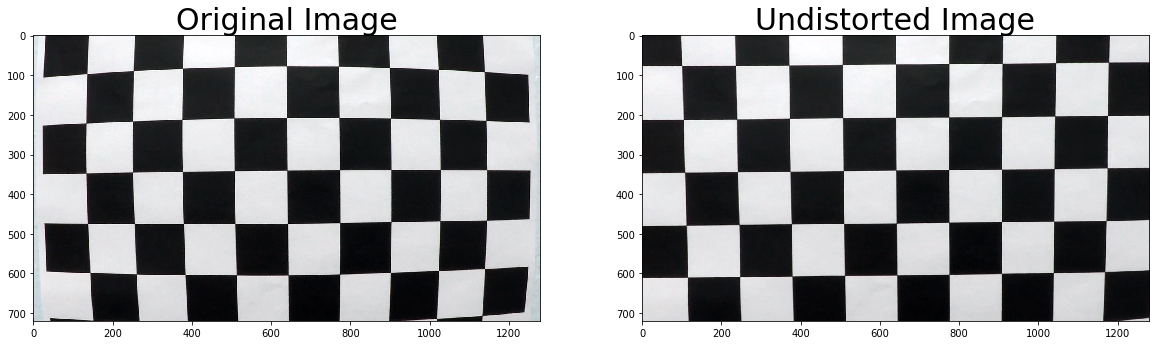

In [2]:
#define the chessboard's point
nx = 9
ny = 5

#prepare object point, like (0, 0, 0), (1, 0, 0), (2, 0, 0)...., (9, 5, 0)
objp = np.zeros((nx*ny, 3), np.float32)
objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1, 2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
    
    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

# Test undistortion on an image
distored_image = cv2.imread('camera_cal/calibration1.jpg')
img_size = (distored_image.shape[1], distored_image.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)

undistorted_image = cv2.undistort(distored_image, mtx, dist, None, mtx)
cv2.imwrite('camera_cal/undist_calibration1.jpg',undistorted_image)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(distored_image)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(undistorted_image)
ax2.set_title('Undistorted Image', fontsize=30)

# Pipeline (single images)
## undistorted image

Text(0.5,1,'Undistorted Image')

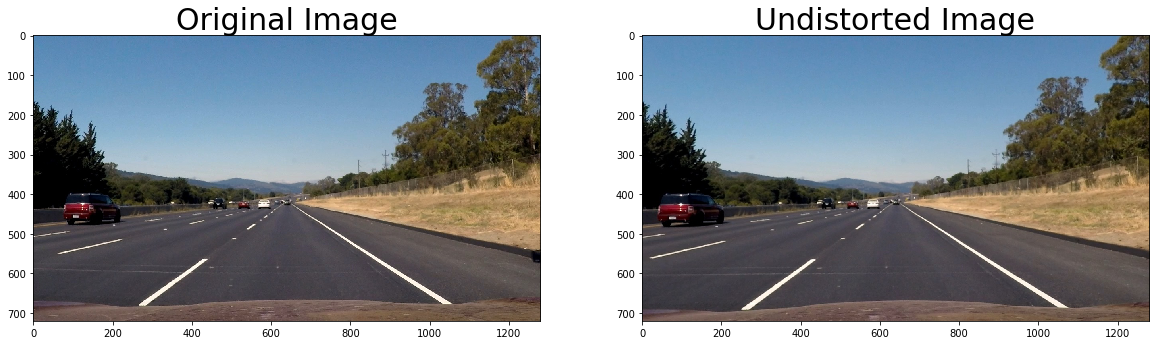

In [12]:
dis_image_path = './test_images/straight_lines2.jpg'

dis_image = mping.imread(dis_image_path)

undistorted_image = cv2.undistort(dis_image, mtx, dist, None, mtx)
cv2.imwrite('camera_cal/undist_calibration1.jpg',undistorted_image)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(dis_image)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(undistorted_image)
ax2.set_title('Undistorted Image', fontsize=30)

# combination of color and gradient thresholds

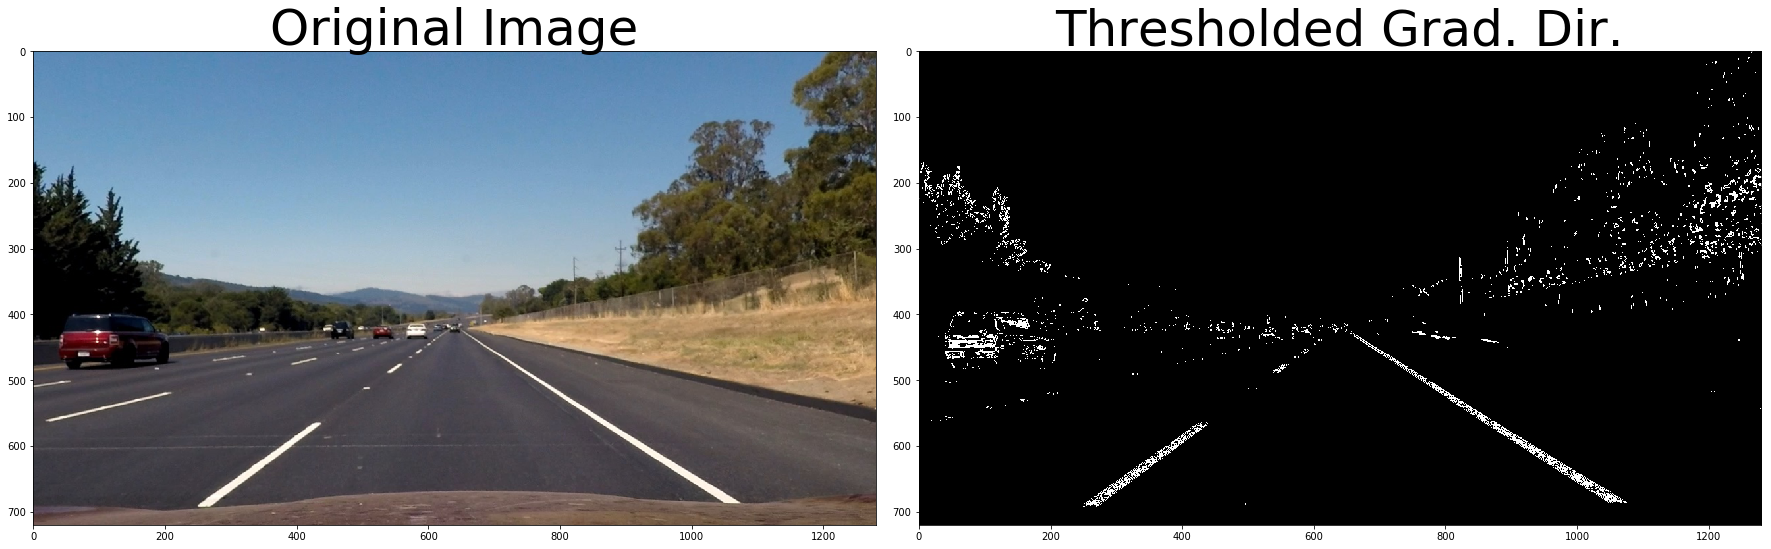

In [13]:
def pipeline(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    img = np.copy(img)
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
#     color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
    color_binary  = np.zeros_like(sxbinary)
    color_binary[(sxbinary != 0) | (s_binary != 0)] = 1
    return color_binary
    
thre_image = pipeline(undistorted_image, (170, 250), (50, 100))

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(undistorted_image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(thre_image, cmap = 'gray')
ax2.set_title('Thresholded Grad. Dir.', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

# Perspective Transform

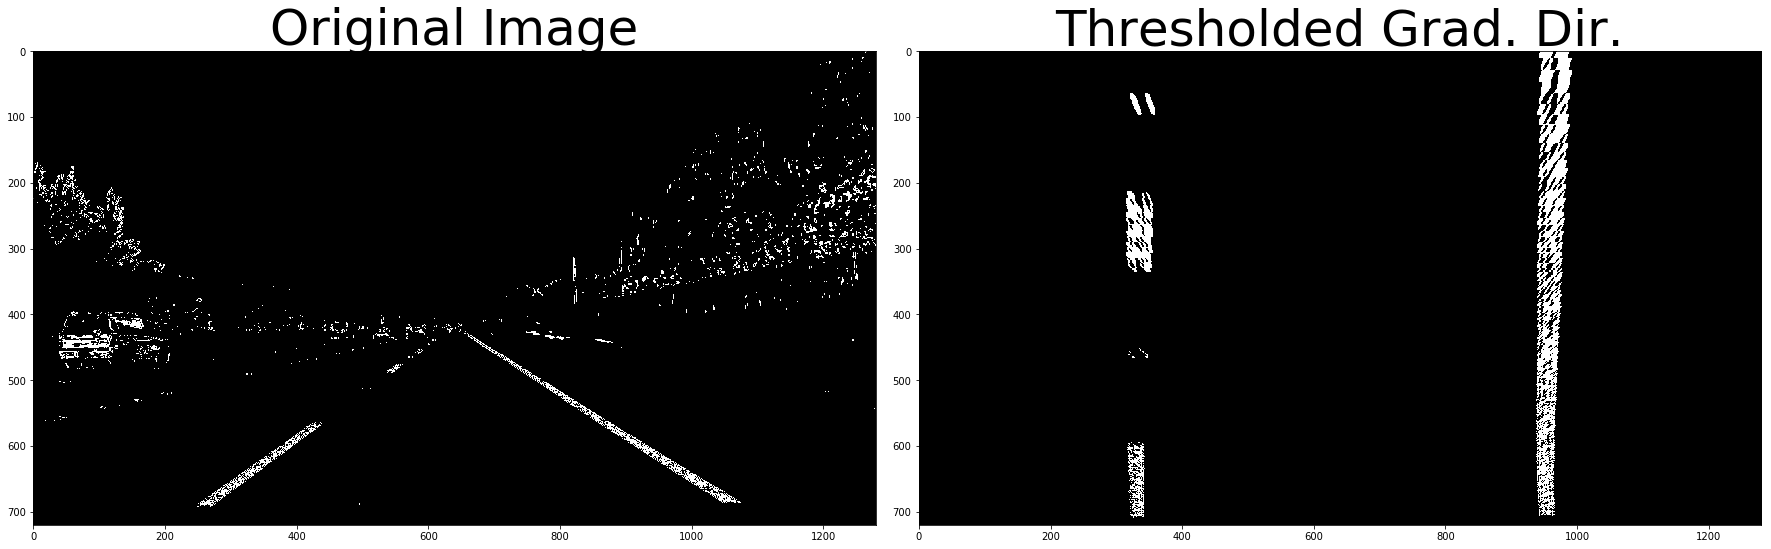

In [15]:
def warper(img):
    offset = 10
    img_size = (img.shape[1], img.shape[0])
    src = np.float32(
        [[(img_size[0] / 2 - (55 + offset)), img_size[1] / 2 + 100],
        [((img_size[0] / 6) - 10), img_size[1]],
        [(img_size[0] * 5 / 6) + 60, img_size[1]],
        [(img_size[0] / 2 + (55 + offset)), img_size[1] / 2 + 100]])
    dst = np.float32(
        [[(img_size[0] / 4), 0],
        [(img_size[0] / 4), img_size[1]],
        [(img_size[0] * 3 / 4), img_size[1]],
        [(img_size[0] * 3 / 4), 0]])
    
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)

    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    
    return warped, M, Minv

warped_image, M, Minv = warper(thre_image)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(thre_image, cmap='gray')
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(warped_image, cmap='gray')
ax2.set_title('Thresholded Grad. Dir.', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

# identified lane-line pixels and fit their positions with a polynomial

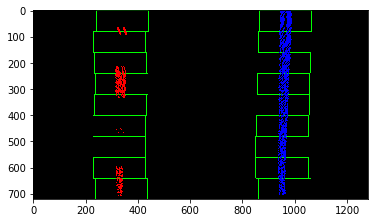

In [16]:
def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        ### TO-DO: Find the four below boundaries of the window ###
        win_xleft_low = leftx_current - margin  # Update this
        win_xleft_high = leftx_current + margin # Update this
        win_xright_low = rightx_current - margin # Update this
        win_xright_high = rightx_current + margin # Update this
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        # good_left_inds = []
        # good_right_inds = []
        # ### TO-DO: Identify the nonzero pixels in x and y within the window ###
        # for left_x in (win_xleft_low, win_xleft_high):
        #     for left_y in (win_y_low, win_y_high):
        #         if left_x in nonzerox :
        #             if left_y in nonzeroy:
        #                 good_left_inds.append([left_x, left_y])
        # for right_x in (win_xright_low, win_xright_high):
        #     for right_y in (win_y_low, win_y_high):
        #         if right_x in nonzerox :
        #             if right_y in nonzeroy:
        #                 good_right_inds.append([right_x, right_y])
        
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # # Append these indices to the lists
        # left_lane_inds.append(np.reshape(good_left_inds, (-1, 2)))
        # right_lane_inds.append(np.reshape(good_right_inds, (-1, 2)))
        
        ### TO-DO: If you found > minpix pixels, recenter next window ###
        ### (`right` or `leftx_current`) on their mean position ###
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
        
        # if len(good_left_inds) > minpix:
        #     leftx_current = np.mean(good_left_inds[0])
        #     rightx_current = np.mean(good_right_inds[0])

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img


def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    ### TO-DO: Fit a second order polynomial to each using `np.polyfit` ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

#     # Plots the left and right polynomials on the lane lines
#     plt.plot(left_fitx, ploty, color='yellow')
#     plt.plot(right_fitx, ploty, color='yellow')

    return out_img, left_fit, right_fit


out_img, left_fit, right_fit = fit_polynomial(warped_image)
plt.imshow(out_img)

# # Plot the result
# f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
# f.tight_layout()
# ax1.imshow(warped_image, cmap='gray')
# ax1.set_title('Original Image', fontsize=50)
# ax2.imshow(out_img, cmap='gray')
# ax2.set_title('Fit_polynomial.', fontsize=50)
# plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

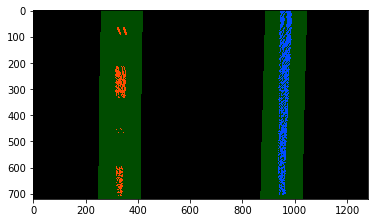

In [17]:
def fit_poly(img_shape, leftx, lefty, rightx, righty):
    ### TO-DO: Fit a second order polynomial to each with np.polyfit() ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    ### TO-DO: Calc both polynomials using ploty, left_fit and right_fit ###
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return left_fitx, right_fitx, ploty

def search_around_poly(binary_warped):
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    # The quiz grader expects 100 here, but feel free to tune on your own!
    margin = 80

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    ### TO-DO: Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    ### Hint: consider the window areas for the similarly named variables ###
    ### in the previous quiz, but change the windows to our new search area ###
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
    left_fitx, right_fitx, ploty = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)
    
    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))
 
    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
#     # Plot the polynomial lines onto the image
#     plt.plot(left_fitx, ploty, color='yellow')
#     plt.plot(right_fitx, ploty, color='yellow')
    ## End visualization steps ##
    
    return result, left_fitx, right_fitx, ploty

# Run image through the pipeline
# Note that in your project, you'll also want to feed in the previous fits
result, left_fitx, right_fitx, ploty = search_around_poly(warped_image)

# View your output
plt.imshow(result)

# calculated the radius of curvature of the lane and the position of the vehicle with respect to center

In [50]:
import numpy as np
    
def measure_curvature_real(left_fitx, right_fitx, ploty):
    '''
    Calculates the curvature of polynomial functions in meters.
    '''
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    ploty_real = ploty*ym_per_pix
    left_fit_real = left_fitx*xm_per_pix
    right_fit_real = right_fitx*xm_per_pix
    left_fit_cr = np.polyfit(ploty_real, left_fit_real, 2)
    right_fit_cr = np.polyfit(ploty_real, right_fit_real, 2)
    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty_real)
    
    ##### the calculation of R_curve (radius of curvature) #####
    left_curverad = (1+(2*left_fit_cr[0]*y_eval + left_fit_cr[1])**2)**1.5 /(np.absolute(2*left_fit_cr[0])) 
    right_curverad = (1+(2*right_fit_cr[0]*y_eval + right_fit_cr[1])**2)**1.5 /(np.absolute(2*right_fit_cr[0])) 
    
    left_post = left_fit_cr[0]*(y_eval**2) + left_fit_cr[1]*y_eval + left_fit_cr[0]
    right_post = right_fit_cr[0]*(y_eval**2) + right_fit_cr[1]*y_eval + right_fit_cr[0]
    
    ver_center_post = (right_post + left_post)/2
    average_curverad = (left_curverad + right_curverad)/2
#     print(right_post, left_post, ver_center_post)
    return average_curverad, ver_center_post


# Calculate the radius of curvature in meters for both lane lines
average_curverad, ver_center_post = measure_curvature_real(left_fitx, right_fitx, ploty)

print(average_curverad, 'm', ver_center_post, 'm')

16637.960257324037 m -0.07404315723954286 m


In [ ]:
def find_line(dis_image):
    #undistort image
    global mtx, dist
    undistorted_image = cv2.undistort(dis_image, mtx, dist, None, mtx)
    
    #create a thresholded binary image
    thre_image = pipeline(undistorted_image, (170, 250), (50, 100))
    
    #perform a perspective transform
    warped_image, M, Minv = warper(thre_image)
    
    #find the lane lines
    out_img, left_fit, right_fit = fit_polynomial(warped_image)
    
    # Run image through the pipeline
    # Note that in your project, you'll also want to feed in the previous fits
    result, left_fitx, right_fitx, ploty = search_around_poly(warped_image)
    
    # Calculate the radius of curvature in meters for both lane lines
    average_curverad, ver_center_post = measure_curvature_real(left_fitx, right_fitx, ploty)
    
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(warped_image)

    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped_image).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    color_warp[lefty, leftx] = [255, 0, 0]
    color_warp[righty, rightx] = [0, 0, 255]

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (undistorted_image.shape[1], undistorted_image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undistorted_image, 1, newwarp, 0.3, 0)
    
#     plt.text(10, 100, ('Radius of Curvature = %.2f(m)' % left_curverad), size = 20, family = "fantasy", color = "r", style = "italic", weight = "light")
#     plt.text(10, 200, ('Vehicle is %.2f m left of center' % ver_center_post), size = 20, family = "fantasy", color = "g", style = "italic", weight = "light")
    font = cv2.FONT_HERSHEY_SIMPLEX
    # 图像，文字内容， 坐标 ，字体，大小，颜色，字体厚度
    cv2.putText(result, ('Radius of Curvature = %.2f(m)' % average_curverad), (50, 100), font, 1.7, (255, 255, 255), 3)
    cv2.putText(result, ('Vehicle is %.2f m left of center' % ver_center_post), (50, 200), font, 1.7, (255, 255, 255), 3)
    
    return result


dis_image_path = './test_images/test6.jpg'
dis_image = mping.imread(dis_image_path)
result = find_line(dis_image)
plt.imshow(result)

# Process video

In [52]:
white_output = 'Pipeline_video.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(find_line) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

print(firstim)

[MoviePy] >>>> Building video Pipeline_video.mp4
[MoviePy] Writing video Pipeline_video.mp4



 12%|█▏        | 152/1261 [00:30<03:39,  5.06it/s]


 24%|██▍       | 303/1261 [00:58<03:03,  5.22it/s]


 36%|███▌      | 454/1261 [01:22<02:25,  5.54it/s]


 48%|████▊     | 605/1261 [01:49<01:58,  5.54it/s]


 60%|█████▉    | 756/1261 [02:14<01:29,  5.63it/s]


 72%|███████▏  | 907/1261 [02:36<01:01,  5.80it/s]


 84%|████████▍ | 1057/1261 [02:58<00:34,  5.92it/s]


 96%|█████████▌| 1205/1261 [03:23<00:09,  5.93it/s]


100%|█████████▉| 1260/1261 [03:32<00:00,  5.93it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: Pipeline_video.mp4 

CPU times: user 3min 33s, sys: 29.1 s, total: 4min 2s
Wall time: 3min 33s


NameError: name 'firstim' is not defined

In [53]:
HTML("""
<video width="640" height="300" controls>
  <source src="{0}">
</video>
""".format(white_output))